We have data about the extent of the northern sea ice measured monthly from years 1978 - 2017. The aim is to fit linear gaussian to the measurements and be able to predict the extent of the ice for the future years. (Perhaps even infere the probability that the ice coverage is shrinking, p(beta < 0) = ?)



#### Description of the model:

We are fitting Gaussian linear model for the data.

#### Prior choices:

We use weakly informative prior for the parameters $\alpha$ and $\beta$. The prior of $\alpha$ is weakly informative being centered at the mean of the measured ice extent with variance of 100.

The prior for $\beta$ carries more information. Though we are not making assumption whether the extent increases or decreases, we are assuming that the change of the extent is limited per year. We have zero mean and 0.5 variance.

Load plot the data:

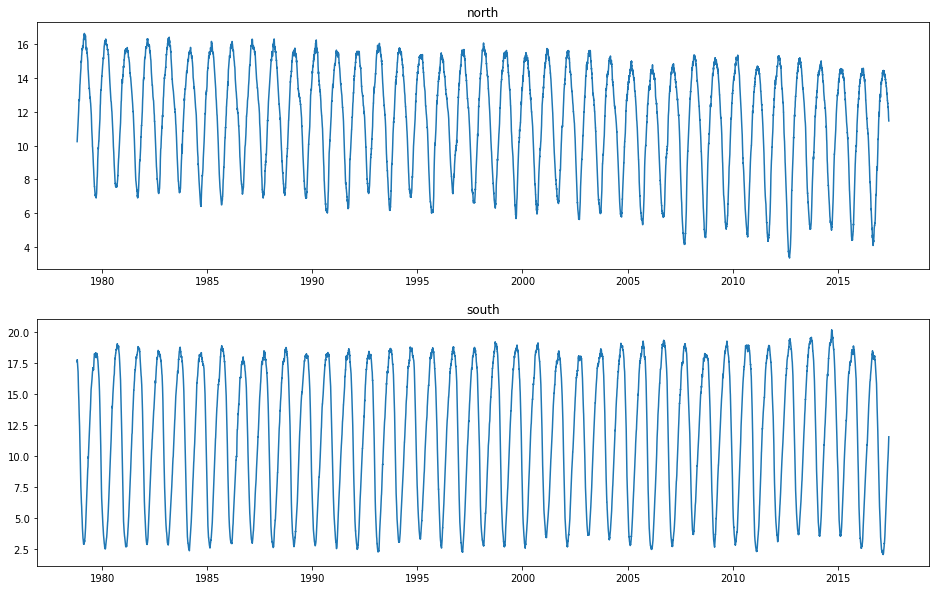

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import timedelta, date, datetime

# load the data
data = pd.read_csv('Data/seaice.csv').values

# the first half is for northern sea ice extent, the second for the southern
N = int(data.shape[0] / 2)
extent_north = data[:N, 3]
extent_south = data[N:, 3]

# parse the dates into a list of datetime.date objects
dates = [0]*N
for i in range(N):
    year = int(data[i, 0])
    month = int(data[i, 1])
    day = int(data[i, 2])
    dates[i] = date(year, month, day)
dates = sorted(dates)

# plot the data
plt.figure(1, figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.plot(dates, extent_north)
plt.title('north')
plt.subplot(2, 1, 2)
plt.title('south')
plt.plot(dates, extent_south)
plt.show()

Take the annual mean extent:

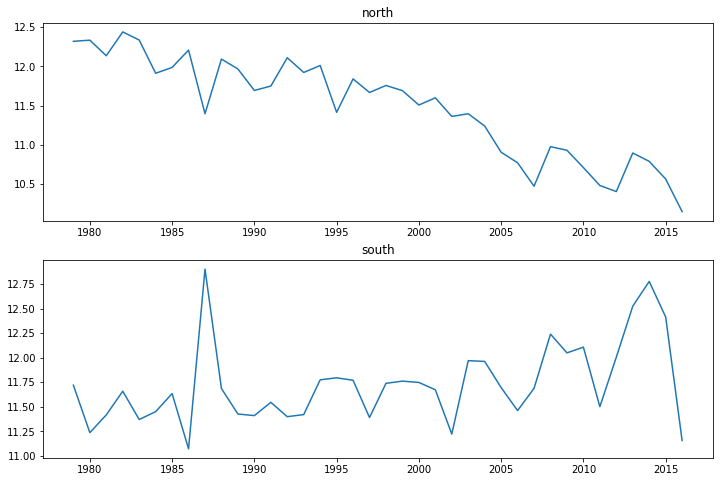

In [69]:
# calculate the average extent for each year
annual_means_north = [0]*40
annual_means_south = [0]*40
daycounts = [0]*40
current_year = 1978
i = 0
for year_index in range(40): # 1978 - 2017 = 40 years
    extent_sum_north = 0
    extent_sum_south = 0
    daycount = 0
    while(True):
        if(current_year == data[i, 0]):
            extent_sum_north += extent_north[i]
            extent_sum_south += extent_south[i]
            daycount += 1
            i += 1
        else:
            annual_means_north[year_index] = extent_sum_north / daycount
            annual_means_south[year_index] = extent_sum_south / daycount
            daycounts[year_index] = daycount
            current_year += 1
            break

# plot the average
plt.figure(2, figsize=(12, 8))
plt.subplot(2, 1, 1)
# omit first and last year because they are not whole
x = np.arange(1979, 2017)
y_north = np.array(annual_means_north[1:-1])
plt.plot(x, y_north) 
plt.title('north')
plt.subplot(2, 1, 2)
plt.title('south')
y_south = annual_means_south[1:-1]
plt.plot(x, y_south)
plt.show()

The numbers of days is smaller for years before 1988. This might skew the results in one way or another. Note year 1987, the extent seems too low in north and too high in south.

In [70]:
print(daycounts)

[34, 182, 183, 183, 182, 183, 183, 182, 183, 220, 354, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 158]


The Stan model (from the pystan demos):

In [71]:
import pystan
# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import stan_utility
with open('lin.stan') as file:
    print(file.read())

// Gaussian linear model with adjustable priors
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
  real pmualpha; // prior mean for alpha
  real psalpha;  // prior std for alpha
  real pmubeta;  // prior mean for beta
  real psbeta;   // prior std for beta
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
  alpha ~ normal(pmualpha, psalpha);
  beta ~ normal(pmubeta, psbeta);
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(alpha + beta*xpred, sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}


Using cached StanModel


Inference for Stan model: anon_model_1efff4822db8c0b931f9364e15aaaf89.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        117.1    0.23   7.85 101.41 111.72 117.35 122.35  132.3   1145    1.0
beta         -0.05  1.2e-4 3.9e-3  -0.06  -0.06  -0.05  -0.05  -0.05   1145    1.0
sigma         0.26  1.0e-3   0.03    0.2   0.24   0.26   0.28   0.33   1132    1.0
mu[1]        12.46  2.2e-3   0.08  12.29   12.4  12.46  12.51  12.62   1410    1.0
mu[2]         12.4  2.1e-3   0.08  12.24  12.35   12.4  12.46  12.56   1438    1.0
mu[3]        12.35  2.0e-3   0.08   12.2   12.3  12.35   12.4   12.5   1471    1.0
mu[4]         12.3  1.9e-3   0.07  12.15  12.25   12.3  12.35  12.44   1510    1.0
mu[5]        12.24  1.8e-3   0.07   12.1   12.2  12.25  12.29  12.38   1556    1.0
mu[6]        12.19  1.7e-3   0.07  12.06  12.15  12.19  12.24  1

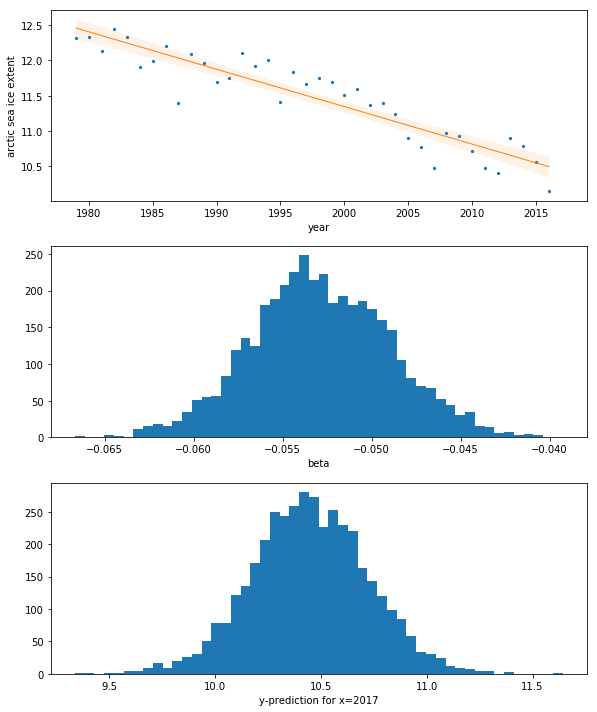

In [72]:
y_north_mean = np.mean(y_north)
n_years = 38
xpred = 2017
data = dict(
    N = n_years,
    x = x,
    y = y_north,
    xpred = xpred,
    pmualpha = y_north_mean,    # centered
    psalpha  = 100,             # weakly informative prior
    pmubeta  = 0,               # a priori increase and decrese as likely
    psbeta   = (.5--.5)/2.0     # the extent of the ice doesn't decrease more than 0.5 per year
                    
)

if __name__ == '__main__':
    model = stan_utility.compile_model('lin.stan')
    fit = model.sampling(data, seed=1)
    print(fit)
    samples = fit.extract(permuted=True)

    # make slightly wider figure of 3 plots
    figsize = plt.rcParams['figure.figsize'].copy()
    figsize[0] *= 1.4  # width
    figsize[1] *= 2.5  # height
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # plot 1: scatterplot and lines
    color_scatter = 'C0'  # 'C0' for default color #0
    color_line = 'C1'     # 'C1' for default color #1
    # lighten color_line
    color_shade = (
        1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
    )
    # plot
    ax = axes[0]
    ax.fill_between(
        x,
        np.percentile(samples['mu'], 5, axis=0),
        np.percentile(samples['mu'], 95, axis=0),
        color=color_shade
    )
    ax.plot(
        x,
        np.percentile(samples['mu'], 50, axis=0),
        color=color_line,
        linewidth=1
    )
    ax.scatter(x, y_north, 5, color=color_scatter)
    ax.set_xlabel('year')
    ax.set_ylabel('arctic sea ice extent')
    ax.set_xlim((1977, 2019))

    # plot 2: histogram
    ax = axes[1]
    ax.hist(samples['beta'], 50)
    ax.set_xlabel('beta')

    # plot 3: histogram
    ax = axes[2]
    ax.hist(samples['ypred'], 50)
    ax.set_xlabel('y-prediction for x={}'.format(xpred))

    # make figure compact
    fig.tight_layout()
    plt.show()

#### Convergence diagnostics:

Rhat values for the $\alpha$ and $\beta$ are 1.0, so the chains have converged.

In [73]:
print("According to the model, the probability that the ice extent is decreasing: ")
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta'] < 0)))

According to the model, the probability that the ice extent is decreasing: 
Pr(beta > 0) = 1.0


##### Model comparison (e.g. with loo)


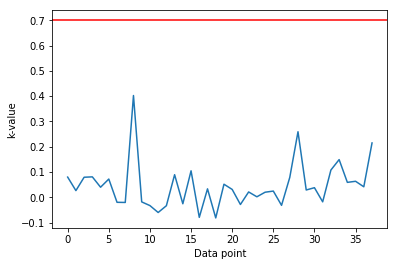

Estimated effective number of parameters:  3.24086919446
PSIS-LOO value:  -3.15561841322


In [74]:
import psis
log_liks = samples["log_lik"]

loo, loos, ks = psis.psisloo(log_liks)
plt.plot(ks)
plt.axhline(y=0.7, color='r', linestyle='-')
plt.xlabel('Data point')
plt.ylabel('k-value')

plt.show()

#equations 7.5  and 7.15 from BDA 3rd edition, A.Vehtari et al
def p_eff(log_liks, loo):
    lppd = np.sum(np.log(np.mean(np.exp(log_liks))))
    return lppd - loo

print("Estimated effective number of parameters: ", p_eff(log_liks, loo))
print("PSIS-LOO value: ", loo)

    

The pareto k-shape values are all below 0.7 so the PSIS-LOO estimate can be considered reliable.

#### Discussion of problems and potetial improvements